# Alexis Groshenry and Julien Bergerot - Deformation of faces using a drawing
12 Dec 2020

This idea came to us while we were scrolling on Instagram and run into this [page](https://www.instagram.com/thingsihavedrawn), *ThingsIHaveDrawn*. Although these results are obtained via photoshop, we wanted to automate this computation on faces.

This work is divised in different part. First of all, we needed to extract faces features from one's face. Then, we were also required to do it on the drawing presented. Finally, we needed to compute the deformation observed in the drawing, on the original face.

## Necessary packages

We used cv2 for image processing, especially for the features extraction. The dlib and Delaunay library will be discussed in the relevant part.

In [1]:
# import the necessary packages
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2
from math import *
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.spatial import Delaunay
from scipy import ndimage
from scipy.interpolate import interp1d

### Drawing and image

We reshape the image according to the drawing's size.

In [2]:
# init the drawing and picture
dessin = cv2.imread('drawings/thin.png') 
image = cv2.imread("images/photo.png")
# resize
image = cv2.resize(image,dessin.shape[:2][::-1])

## Extract drawing features

We assume that a feature is a line that is not cut in different part, and opened. Therefore, each feature contains 2 extremities, that we will compute, so as to understand where is the first point of the feature.

In [3]:
# get the extremities so as to start at the correct place
# careful for the drawing : extremities must contain only one neighbor


def find_feature_ext(father,i,j,nb_features,union,res_dr,points_dr):
    # according to a point of coordinate (i,j) we will look whether its 8 neighbors are in the same feature
    grad_x = [-1,0,1]
    grad_y = [-1,0,1]
    n,m = union.shape
    for e1 in grad_x:
        for e2 in grad_y:
            x=i+e1
            y=j+e2
            if m*x+y!=father and dessin[x,y,0]!=255. and union[x,y]==m*x+y:    
                union[x,y]=father
                points_dr[father][x,y] = get_neighbors(x,y,dessin)
                find_feature_ext(father,x,y,nb_features,union,res_dr,points_dr)
                

def get_extremities(img) :
    # given the drawing, will return the number of neighbors for each point that is not white
    
    # the points of the drawing
    points_dr = {}    
    
    # union find for all the features
    union=np.zeros(dessin.shape[:2])
    (n,m)=union.shape
    for i in range(n):
        for j in range(m):
            union[i,j]=m*i+j
            

    res_dr = {} # temporary contains the points, that still need labeling before going into res
    nb_features=0
    for j in range(m):
        for i in range(n):
            if dessin[i,j,0]==255.:
                union[i,j]=0
            #premier pixel d'un feature
            elif union[i,j]==m*i+j:
                points_dr[m*i+j] = {}
                points_dr[m*i+j][i,j] = get_neighbors(i,j,dessin)
                
                find_feature_ext(m*i+j,i,j,nb_features,union,res_dr,points_dr)
                res_dr[str(nb_features)] = points_dr[m*i+j]
                nb_features+=1
    return res_dr

def get_neighbors(i,j,dessin) :
    # numbers of neighbors of the (i,j) point
    S = -1
    neighbors = []
    for e1 in [-1,0,1] :
        for e2 in [-1,0,1] : 
            if dessin[i+e1,j+e2,0] != 255 :
                S +=1
                neighbors.append([i+e1,j+e2])
    
    return S

### Extremities extraction

For each feature, the extremities are the point with one neighbor. Then according to the two extremities, the first will be the closest to the origin.

In [4]:
res = get_extremities(dessin)
ext = []
for k in res : 
    current_ext = []
    for key,values in res[k].items() :
        if values == 1 :
            current_ext.append(key)
    # how to choose? closest to (0,0)
    norm0 = np.linalg.norm(np.array(current_ext[0]))
    norm1 = np.linalg.norm(np.array(current_ext[1]))
    if norm0 > norm1 :
        ext.append(current_ext[1])
    else : 
        ext.append(current_ext[0])        

## Extration of features

We will now look at every extremities selected and deduced a feature. Then the user will be asked to assert the part each feature represent. At first, we wanted to use a neural network to label those shapes, but the purpose of the drawing is to completely change the features, so something looking like an eye, may just be the mouth the user has drawn.

In [5]:
def find_feature(father,i,j,nb_features,union,res_draw,res_dr,points_dr):
    # according to a point we know is on the feature identified as *father*, we check if its neighbors are also.
    grad_x = [-1,0,1]
    grad_y = [-1,0,1]
    n,m = union.shape
    for e1 in grad_x:
        for e2 in grad_y:
            x=i+e1
            y=j+e2
            if m*x+y!=father and dessin[x,y,0]!=255. and union[x,y]==m*x+y:    
                union[x,y]=father
                points_dr[father].append([y,x])
                res_draw[str(nb_features)][x,y] = 255
                find_feature(father,x,y,nb_features,union,res_draw,res_dr,points_dr)
                

def compute_init_drawing() :
    # the points of the drawing
    points_dr = {}    
    
    # union find for all the features
    union=np.zeros(dessin.shape[:2])
    (n,m)=union.shape
    for i in range(n):
        for j in range(m):
            union[i,j]=m*i+j
            
    res = {} # final result, after getting the right label
    res_draw = {} # contains one image per feature, to help labeling
    res_dr = {} # temporary contains the points, that still need labeling before going into res
    nb_features = 0
    
    # we will look for each feature that we found previously
    for x,y in ext :
        points_dr[m*x+y] = [[y,x]]
        res_draw[str(nb_features)] = np.zeros(union.shape)
        res_draw[str(nb_features)][x,y] = 255
        find_feature(m*x+y,x,y,nb_features,union,res_draw,res_dr,points_dr)
        res_dr[str(nb_features)] = points_dr[m*x+y]
        nb_features+=1
        
    # asking which part it is            
    for k in res_draw :
        plt.imshow(res_draw[k])
        plt.show()
        feature = input("Which feature is it ?")
        res[feature] = res_dr[k]
        
    return res

### Feature extraction

The following line will use the previously explained function.

> **Careful :** The only available labels are : 
> 
> 
> - hair
> - right_eye
> - left_eye
> - right_eyebrow
> - left_eyebrow
> - jaw
> - mouth

The result will be kept in *res_d*.

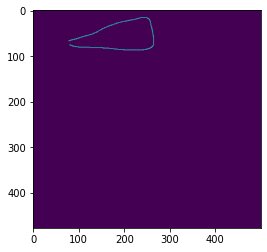

Which feature is it ?hair


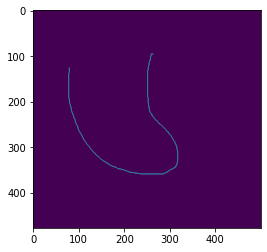

Which feature is it ?jaw


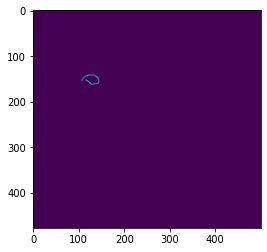

Which feature is it ?right_eye


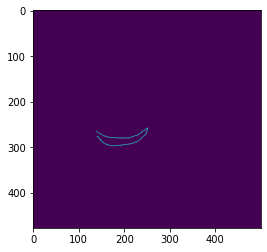

Which feature is it ?mouth


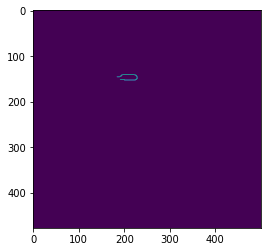

Which feature is it ?left_eye


In [6]:
res_d = compute_init_drawing()

## Face feature extraction

We used a pretrained model for face detection taken from this [page](https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/). This requires the dlib library and a pretrained model. The algorith explained in this tutorial contains some important points to describe each feature. Our principal function takes the image as an input and returns a dictionnary, containing, for each feature, the points. 

In [7]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of (x, y)-coordinates
    return coords

def compute_init_pict(image) :
    # initialize dlib's face detector (HOG-based) and then create
    # the facial landmark predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("model/shape_predictor_68_face_landmarks.dat")
    # load the input image, resize it, and convert it to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # detect faces in the grayscale image
    rects = detector(gray, 1)

    # loop over the face detections
    res = {}
    for rect in rects:
        # determine the facial landmarks for the face region, then
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        # loop over the face parts individually
        for (name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
            res[name] = {}
            res[name]["points"] = []
            # clone the original image so we can draw on it, then
            # display the name of the face part on the image
            for (indice,(x, y)) in enumerate(shape[i:j]):
                res[name]["points"].append(shape[i:j][indice])

    mat_res = np.zeros(image.shape[:2])

    return res

### Extract features

The result will be kep in *res_im*.

In [8]:
res_im = compute_init_pict(image)

## More features

As you can see on the documentation page, the pretrained model does not extract anything above the eye. Therefore, we are trying to extrapolate the position of the hair and forehead. We tried to use parameters found [here](https://www.artyfactory.com/portraits/pencil-portraits/proportions-of-a-head.html) to compute the top of the forehead and the top of the hair.

In [9]:
def get_bottom(L) :
    # return the bottomest point
    bot = L[0][1]
    for k in L :
        if k[1]>bot :
            bot = k[1]
    return bot

def add_hair(res_im) :
    # coordinates of the face
    mid = res_im["jaw"]["points"][0][1]
    left = res_im["jaw"]["points"][0][0]
    right = res_im["jaw"]["points"][-1][0]
    left1 = res_im["right_eye"]["points"][0][0]
    right1 = res_im["left_eye"]["points"][3][0]
    bottom = get_bottom(res_im["jaw"]["points"])
    middle_mouth = res_im["mouth"]["points"][3][0]
    dist = bottom - mid
    
    # points
    top_left = [left,mid-dist]
    top_right = [right,mid-dist]
    hair_left = [left1,int(mid-0.8*dist)]
    hair_right = [right1,int(mid-0.8*dist)]
    top_hair = [middle_mouth,int(mid-1.3*dist)]
    bottom_hair = [middle_mouth,int(mid-0.8*dist)]
    hair = [top_left,top_hair,top_right,hair_right,bottom_hair,hair_left]
    
    res_im["hair"] = {}
    res_im["hair"]["points"] = hair
    return res_im

### Hair and forehead

*res_im* will now contains point of the forehead and hair.

In [10]:
res_im = add_hair(res_im)

## Interpolation

We wanted to have the possibility to add points between the pre-existing points detected via the neural network. To do so, we used cubic interpolation.

Note that *jaw* and *eyebrow* are not closed part so we do not want to compute the whole turn.

In [11]:
# add points according to cubic interpolation
# not so good for now
def add_points(points,part="jaw") :
    if part == "hair" or part == "left_eybrow" or part == "right_eyebrow" :
        return points
    x = []
    y = []
    for a,b in points:
        x.append(a)
        y.append(b)
    if not (part in ["jaw",'left_eyebrow','right_eyebrow']) :
        x.append(points[0][0])
        y.append(points[0][1])
    t = [k for k in range(len(x))]
    new_points = []
    fx = interp1d(t, x, kind='cubic')
    fy = interp1d(t, y, kind='cubic')
    for i in t : 
        try : 
            # last point in the first point if we circle
            if i != len(t)-1 and not(part in ["jaw",'left_eyebrow','right_eyebrow']) :
                x_x = fx(i)
                y_y = fy(i)
                new_points.append([int(x_x),int(y_y)])
            elif (part in ["jaw",'left_eyebrow','right_eyebrow']) : 
                x_x = fx(i)
                y_y = fy(i)
                new_points.append([int(x_x),int(y_y)])
            x_x = fx(i+0.5)
            y_y = fy(i+0.5)
            new_points.append([int(x_x),int(y_y)])
        except :
            print("Okay mistake") # actually not a mistake, but I did not know what to say
    return new_points

### Compute interpolation

Note that their algorith returns points for the inside of the mouth. We do not want these, hence the *[:12]*.
We stock every points in *points_tot*, a dictionnary that, for every feature, contains points of the image and drawing.

In [12]:
points_tot = {}
for k in res_d :
    points_tot[k] = {}
    points_tot[k]["drawing"] = res_d[k]
    if k == 'mouth' :
        points_tot[k]["image"] = add_points(res_im[k]["points"][:12],part=k)
    else :
        points_tot[k]["image"] = add_points(res_im[k]["points"],part=k)

Okay mistake
Okay mistake
Okay mistake
Okay mistake


## Same amount of points

To properly link points of the drawing to points of the image, each feature needs to contain the same amount of points for both. Here, given the number of points selected on the image, we will selected the same number of points from the drawing, evenly spaced.

In [13]:
def good_points(origine,goal) :
    # we have origine points (greater number) and want to obtain as much points as in goal
    n = len(goal)
    count = len(origine)
    obj = []
    interval = count//n
    for i in range(n) :
        obj.append(origine[i*interval])
    return obj

for k in points_tot : 
    points_tot[k]["drawing"] = good_points(points_tot[k]["drawing"],points_tot[k]["image"])

### All in one

Now, we will use a single list for image and drawing, and put all the points in it. The first image point will be link to the first drawing point and so on.

In [14]:
image_points = []
drawing_points = []
for k in points_tot :
    for i in points_tot[k]["image"] :
        image_points.append(i)
    for j in points_tot[k]["drawing"] :
        drawing_points.append(j)

## Delaunay method

This method is used for triangulation. We therefore used it to triangulate the image, because the latter is probably better suited for this (less distorted).

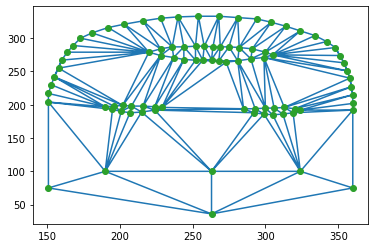

In [15]:
points =np.array([list(coords) for coords in image_points])
drawing_points = np.array([list(coords) for coords in drawing_points])

# compute Delaunay method
tri = Delaunay(points)
faces = tri.simplices # contains the point of each 
# care it is in the wrong sens
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

### Face belonging

The final function will go through every point of the drawing, identified which face it is in, find the coefficients related to the vertices of the face. Given these coefficients, we can compute the point on the image (the face is the one with the vertices index on the face we found on the drawing). Then, we just need to give this point the value of the pixel on the image.

We therefore need to have a function returning the face the point is in and the coefficient. These function where found [here](https://stackoverflow.com/questions/1119627/how-to-test-if-a-point-is-inside-of-a-convex-polygon-in-2d-integer-coordinates) and we changed a small part for the points on the edges.

In [16]:
RIGHT = "RIGHT"
LEFT = "LEFT"

def get_min_max(x,y) :
    if x>y : 
        return y,x
    return x,y

# whether the point in inside the polygone, here triangle
def inside_convex_polygon(point, vertices):
    # inside the triangle
    previous_side = None
    n_vertices = len(vertices)
    for n in range(n_vertices):
        a, b = vertices[n], vertices[(n+1)%n_vertices]
        affine_segment = v_sub(b, a)
        affine_point = v_sub(point, a)
        current_side = get_side(affine_segment, affine_point)
        if current_side is None:
            #outside or over an edge
            # check if over an edge
            min_x,max_x = get_min_max(a[0],b[0])
            min_y,max_y = get_min_max(a[1],b[1])
            if point[0] >= min_x and point[0] <= max_x and point[1]>=min_y and point[1] <= max_y :
                return True
            return False #outside
        elif previous_side is None: #first segment
            previous_side = current_side
        elif previous_side != current_side:
            return False
    return True

def on_convexe_polygone(point,vertices) : 
    # on the vertices or edges
    for i in range(len(vertices)) : # will be 3 cause it is a triangle
        if (vertices[i][0] - vertices[(i+1)%len(vertices)][0]) == 0 and vertices[i][1]== point[1] : 
            return False
        if point[1] == (vertices[i][1] - vertices[(i+1)%len(vertices)][1]) / (vertices[i][0] - vertices[(i+1)%len(vertices)][0]) * (point[0] -vertices[i][0]) + vertices[i][1] : 
            return True # aka the point is on the edge betwen vertice[i] and vertice[i+1]
    return False

def get_side(a, b):
    x = cosine_sign(a, b)
    if x < 0:
        return LEFT
    elif x > 0: 
        return RIGHT
    else:
        return None

def v_sub(a, b):
    return (a[0]-b[0], a[1]-b[1])

def cosine_sign(a, b):
    return a[0]*b[1]-a[1]*b[0]

def get_face(point,F,V) :
    # given a point, return the face in which he is contained
    for ind,k in enumerate(F) :
        if inside_convex_polygon(point,[V[k[0]],V[k[1]],V[k[2]]]) :
            return ind 

# point = alpha * point[0] + beta * point[1] + gamma * point[2]
def get_coefs(point,vertices) :
    # one point and the three vertices
    M = np.ones((3,3))
    M[1,0] = vertices[0][0]
    M[1,1] = vertices[1][0]
    M[1,2] = vertices[2][0]
    
    M[2,0] = vertices[0][1]
    M[2,1] = vertices[1][1]
    M[2,2] = vertices[2][1]
    
    Y = np.zeros((3,1))
    Y[0,0] = 1
    Y[1,0] = point[0]
    Y[2,0] = point[1]
    try :
        return inv(M) @ Y
    except :
        # the face is flat
        # If the face is flat, which point are more important?
        default = np.zeros((3,1))
        default[0,0] = np.linalg.norm(np.array(vertices[0])-np.array(point))
        default[1,0] = np.linalg.norm(np.array(vertices[1])-np.array(point))
        default[2,0] = np.linalg.norm(np.array(vertices[2])-np.array(point))
        norm = np.linalg.norm(np.array(vertices[0])-np.array(point)) + np.linalg.norm(np.array(vertices[1])-np.array(point)) +np.linalg.norm(np.array(vertices[2])-np.array(point))
        default = default / norm
        default[0,0] = 1-default[0,0]
        default[1,0] = 1-default[1,0]
        default[2,0] = 1-default[2,0]
        default = default / np.linalg.norm(default)
        return default

## Final result

We the previous functions, we can now compute our desired result.

In [17]:
#result matrix
deformed = np.zeros(dessin.shape)

for i in range(dessin.shape[1]):
    if i%50 == 0 :
        print("Column {} over {}".format(i,dessin.shape[1]))
    for j in range(dessin.shape[0]):
        for f in tri.simplices:
            l=list(drawing_points[v] for v in list(f))
            l2 = list(points[v] for v in list(f))
            if inside_convex_polygon([i,j],l):
                coefs=get_coefs([i,j],l)
                x = int(sum(coefs[i]*l2[i][0] for i in range(3) ))
                y = int(sum(coefs[i]*l2[i][1] for i in range(3) ))
                # a cause des arrondis, sometimes ca dépasse
                if x > dessin.shape[1]-1 :
                    x = dessin.shape[1] -1
                if y > dessin.shape[0]-1 :
                    y = dessin.shape[0] - 1
                deformed[j,i]=image[y,x]
                break

Column 0 over 500
Column 50 over 500
Column 100 over 500
Column 150 over 500
Column 200 over 500
Column 250 over 500
Column 300 over 500
Column 350 over 500
Column 400 over 500
Column 450 over 500


### Result

The result is in *deformed* and can be projected via *plt* or *cv2*.

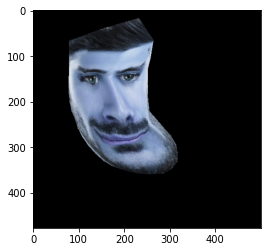

In [54]:
deformed = deformed.astype("uint8")
plt.imshow(deformed)
plt.show()

In [55]:
cv2.imshow("test",deformed)
cv2.waitKey(0)

-1

### Save the result

In [125]:
cv2.imwrite("result/res.png",deformed)

True